In [1]:
#-------------------------
# Libs
#-------------------------
 
# External libs
# %matplotlib qt         Fuck this line right here.
import pymysql.cursors
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
sys.path.append("/home/omalleyian/Documents/energy_market_project/scripts")
from ercot_data_interface import ercot_data_interface
from ARIMA import ARIMA

In [2]:
#-------------------------
# SQL environments
#-------------------------
 
HOST = "localhost"
USER = "root" 
PASSWORD = "Is79t5Is79t5"
DB = "ercot_data"

#-------------------------
# Functions
#-------------------------
"""
Make a connection to MySQL
Execute the MySQL query and return the resutls
"""

def execute_dict_query(query):
    connection = pymysql.connect(host=HOST, 
                                 user=USER, 
                                 password=PASSWORD, 
                                 db=DB, 
                                 port=3306,
                                 cursorclass=pymysql.cursors.DictCursor)
    
    try:
        with connection.cursor() as cursor:
            # Create a new record
            cursor.execute(query)
            result = cursor.fetchall()
            return result
    finally:
        connection.close()

 


In [4]:
# Query data sorted by date and hour. SLOW!
result_dict = execute_dict_query('select * from DAM_LMP0  \
                                where delivery_date < "2016-12-31" \
                                and delivery_date > "2011-01-01" \
                                order by delivery_date, hour_ending')

In [5]:
#Extract some data
prices1 = [i['n0001VICTOR'] for i in result_dict]
prices2 = [i['n0001'] for i in result_dict]
hours = [i['hour_ending'].total_seconds() for i in result_dict]
dates = [i['delivery_date'] for i in result_dict]
plt.plot(prices1)
plt.plot(prices2)
# plt.show()

In [6]:
# Percent Change
k = 24
p_t = np.array(prices1[k:])
p_tk = np.array(prices1[:-k])
v = np.log10(p_t) - np.log10(p_tk)
plt.plot(v)
# plt.show()

# MAPE = mean( (actual - forcast) / actual)

MAPE = np.mean(np.square(p_t-p_tk)/p_t)

In [7]:
# Basic data plot
price1 = [float(i['AMNCOWD_8']) for i in result_dict]
price2 = [float(i['AZLES_K']) for i in result_dict]
price3 = [float(i['n0001']) for i in result_dict]

plt.plot(price1, label='1')
plt.plot(price2, label='2')
plt.plot(price3, label='2')
plt.legend()
# plt.show()


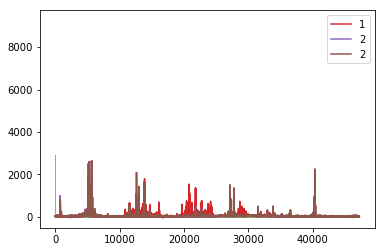

In [8]:
# Histogram
plt.hist(price1, 500)
plt.show()

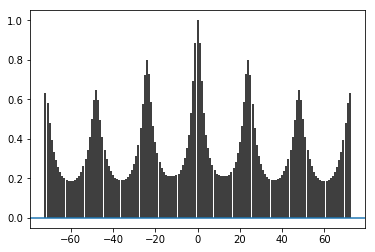

In [9]:
# Autocorrelation
plt.acorr(price1, maxlags=72)
plt.show()

In [10]:
np.mean(price1)

42.479072428819229

In [11]:
#extend this to get prices at different lags e.g. k-1, k-2, k-3
max_lag = 168
p_t = prices1[max_lag:]
X = []
for k in np.arange(0, max_lag, 24):
    t_k = np.array(prices1[(max_lag-k):-k], dtype='float')
    X.append(t_k)
X = np.swapaxes(np.array(X[1:]), 0, 1)
Y = [float(i) for i in p_t]
# use sklearn.LinearRegression to fit (X, Y)

regr = linear_model.LinearRegression()
regr.fit(X,Y)

print regr.predict(X)
plt.plot(X)
# plt.show()


[ 27.76918254  26.23065003  25.4826624  ...,  22.29701492  19.54565128
  17.51651262]


In [16]:
# Mean Model
# Given list X and time t
# Return mean of X from 0 to t

def mean_model(X, t):
    return np.mean(X[:t])

training = prices1[:-24]
test = prices1[-24:]

#MAPE  = np.mean()

print mean_model(training, 24)



29.52041666666666666666666667


In [17]:
# Random Walk Model
# Given list X and time t
# Return element of X at time t-1

def random_walk(X, t):
    return X[t-1]

print random_walk(prices1, 24)

30.14


In [18]:
# Moving Average Model
# Given a list X, time t, and m number of observations
# Return the value of Y at time t of the previous m elements in X.

def moving_average(X, t, m):
    s = sum(X[(t-m):t])
    avg = s/m
    return avg

print moving_average(prices1, 24, 24)
    
    

29.52041666666666666666666667


In [30]:

ercot = ercot_data_interface(password="Is79t5Is79t5")
nodes_crr = ercot.get_CRR_nodes()
nodes_all = ercot.all_nodes
nodes_source = ercot.get_sources_sinks()
df_2011 = ercot.query_prices(nodes_all[0], "2011-01-01","2011-12-31")
df_2012 = ercot.query_prices(nodes_all[0], "2012-01-01","2012-12-31")
matrix_2011 = df.as_matrix()
matrix_2012 = df.as_matrix()

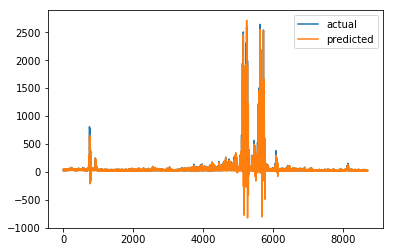

8.39001149219


In [35]:
arima = ARIMA(p = 2, d = 0, q = 0, seasonal = 24)
arima.fit(matrix_2011)
arima.plot_predicted_vs_actual(matrix_2012)
print arima.mae(matrix_2012)